In [1]:
! pip install qiskit
! pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from math import ceil, log2, asin,sqrt,pi
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from random import randint, seed

In [3]:
# database length -> must be a power of two (quantum computer database limitation)
N = 4

In [4]:
# number og qubits
n = ceil(log2(N))

In [5]:
# winner index (random)
#seed(23223423464) # vary the seed to get diferent random winner indexes
winner_index = randint(0,n-1)
winner_index

1

In [6]:
winner_state = bin(winner_index)[2:].zfill(n)
winner_state

'01'

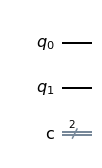

In [7]:
# build quantum circuit
qc = QuantumCircuit(n,n)
qc.draw("mpl")

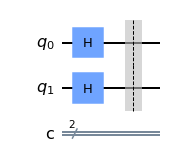

In [8]:
# apply hadamard gates to create superposition
for i in range(n):
  qc.h(i)
qc.barrier()
qc.draw("mpl")

In [9]:
# create the householder reflection operator
def Householder():
    refl = np.identity(N)
    refl[winner_index,winner_index]=-1
    refl_op = Operator(refl)
    n_qubits = [i for i in range(n)]
    qc.unitary(refl_op,qubits=n_qubits, label = 'Uw')
    qc.barrier()
    return qc

In [10]:
Householder()

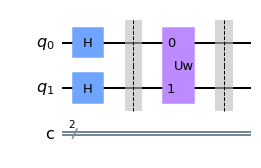

In [11]:
qc.draw("mpl")

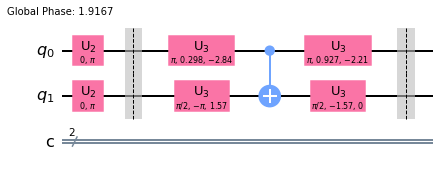

In [12]:
qc.decompose().draw("mpl")

In [13]:
# create the difusion operator
def Difussion():
  for i in range(n):
    qc.x(i)
    qc.h(i)
  controls = [i for i in range(1,n)]
  qc.h(0)
  qc.mct(controls,0)
  qc.h(0)
  qc.barrier()
  for i in range(n):
    qc.x(i)
    qc.h(i)
  qc.barrier()
  return qc

In [14]:
Difussion()

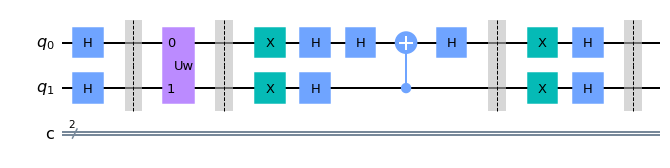

In [15]:
qc.draw("mpl")

In [16]:
# we need to apply the householder and difussion operator t times
theta = asin(1/sqrt(N))
t = ceil(pi/(4*theta)-0.5)

In [17]:
t

1

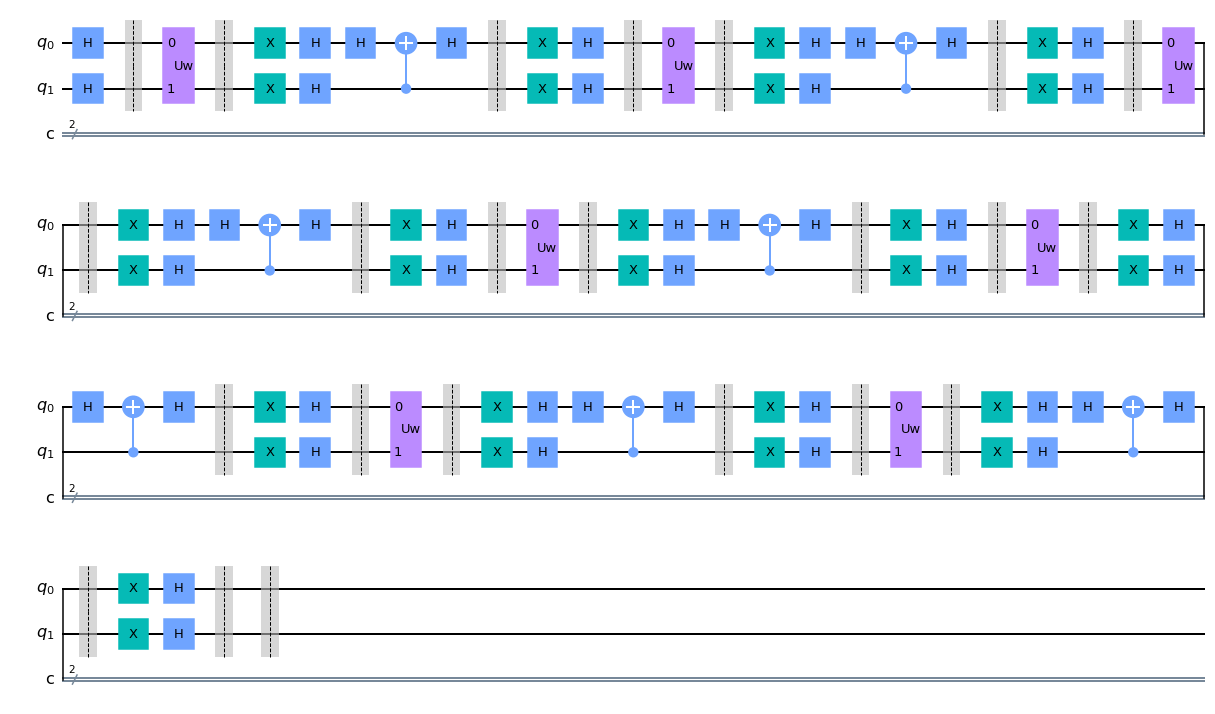

In [18]:
for i in range(t+5): # it has been already applied 1 time (theoretically it must be repeated t-1 but i augmented it because yolo)
  Householder()
  Difussion()
qc.barrier()
qc.draw("mpl")

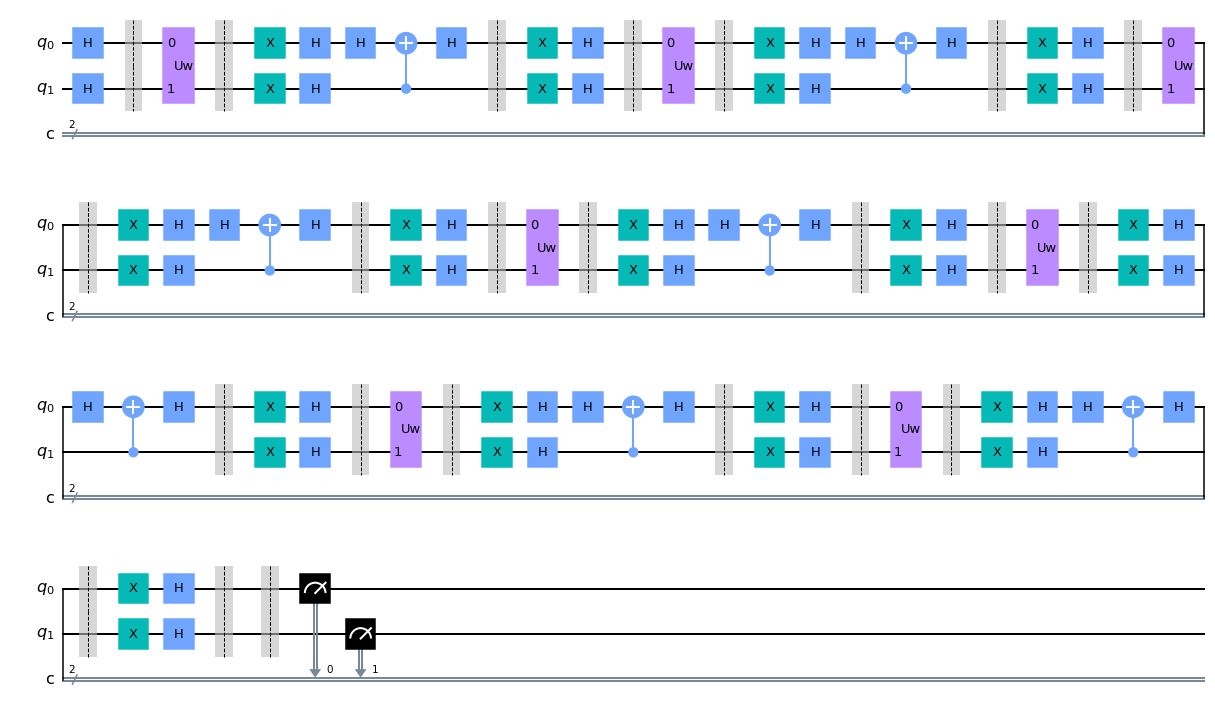

In [19]:
# apply measurments on the qubits
for i in range(n):
  qc.measure(i,i)
qc.draw("mpl")

In [20]:
# execute on an ideal quantum computer
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator
backend = QasmSimulator()
qc_compiled = transpile(qc,backend)
job = backend.run(qc_compiled,shots = 1024)
result = job.result()
counts = result.get_counts()
print(counts)

{'01': 1024}


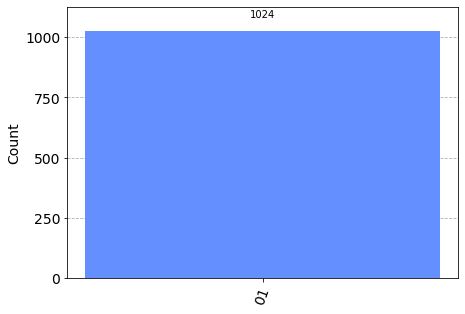

In [21]:
# if the experiment went right, all the measurement should equal the winner index
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [22]:
print(winner_index)

1


In [23]:
# simulate in a mock real quantum computer
from qiskit.providers.fake_provider import FakeMontreal
from qiskit.visualization import plot_error_map, plot_circuit_layout

In [24]:
device_simulation = FakeMontreal()

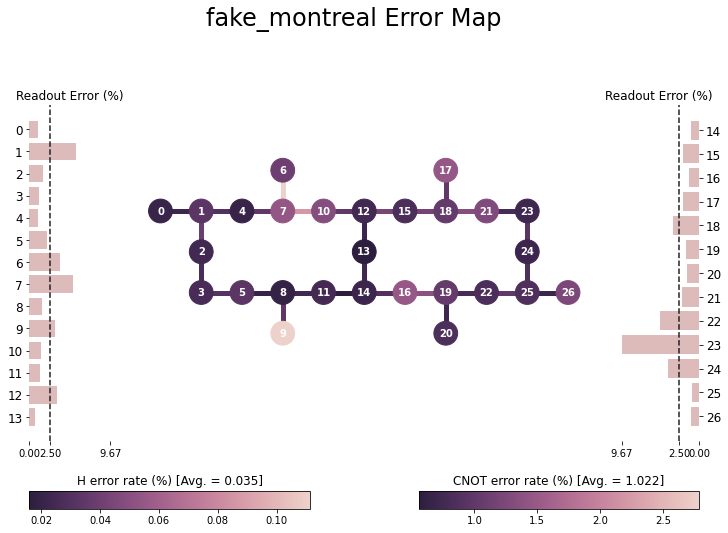

In [25]:
plot_error_map(device_simulation)

In [26]:
qc2 = transpile(qc,device_simulation)

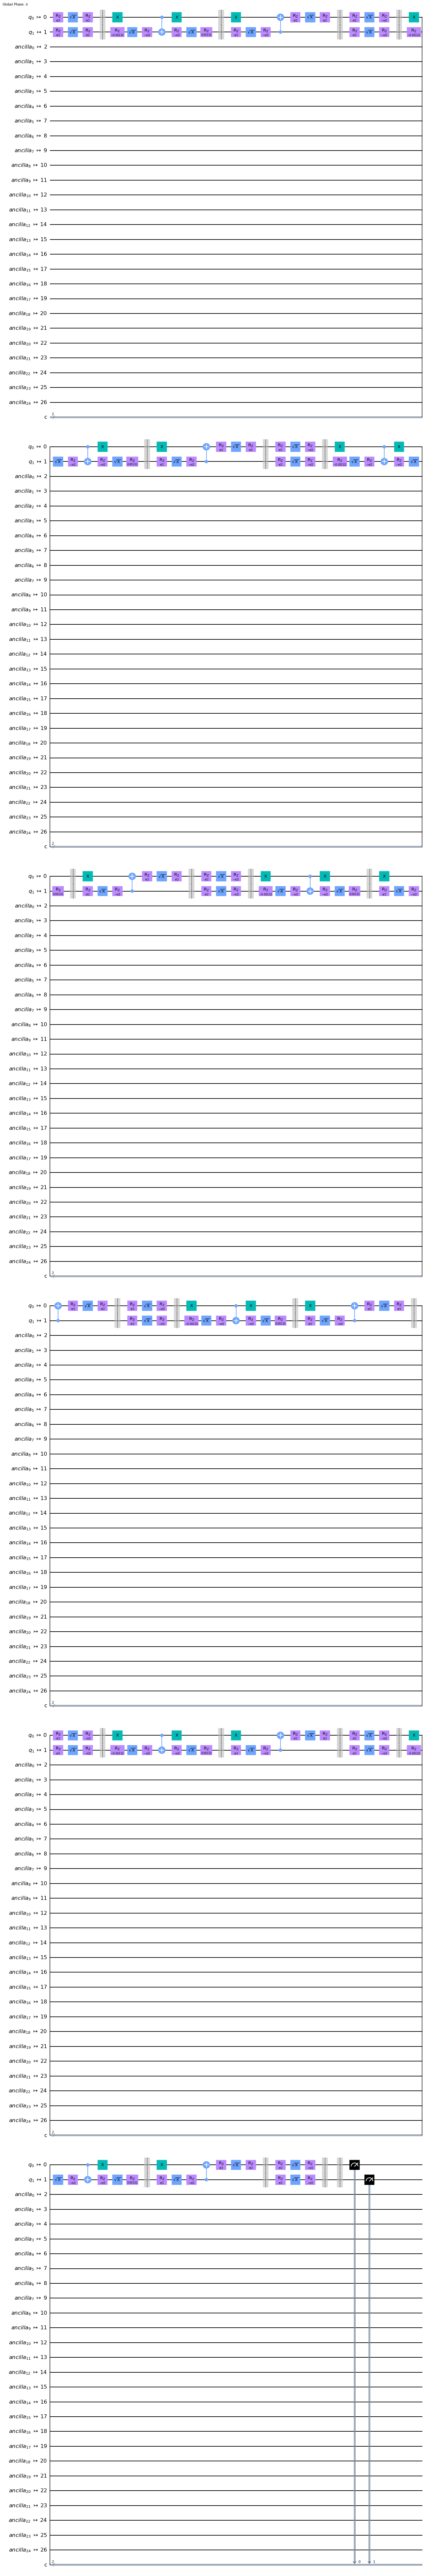

In [27]:
qc2.draw("mpl")

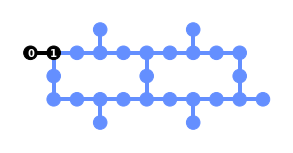

In [28]:
plot_circuit_layout(qc2,device_simulation)

In [29]:
job = device_simulation.run(qc2,shots = 1024)
result = job.result()
counts = result.get_counts()
print(counts)

{'10': 42, '00': 68, '01': 798, '11': 116}


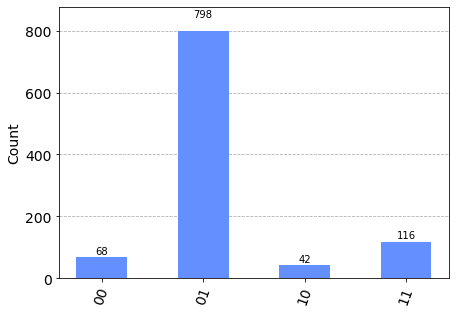

In [30]:
# if the experiment went right, all the measurement should equal the winner index
from qiskit.visualization import plot_histogram
plot_histogram(counts)